## Download Data

In [11]:
!pip install gdown 


[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2

[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Create DataTree

In [1]:
import xml.etree.ElementTree as ET

In [2]:
tree = ET.parse('./data/kaggle/working/ibug_300W_large_face_landmark_dataset/labels_ibug_300W.xml')

In [3]:
root = tree.getroot()

print(type(root))

for child in root:
    print(child.tag, child.attrib)

<class 'xml.etree.ElementTree.Element'>
name {}
comment {}
images {}


In [4]:
images_data = root.find('images')
images_sample = images_data.find('image')
for child in images_sample:
    print(f"Tag: {child.tag}, attributes: {child.attrib}")

Tag: box, attributes: {'top': '206', 'left': '469', 'width': '216', 'height': '216'}


# Process Data

In [5]:
import numpy as np

In [6]:
def sample_image(image):
    """
    Create a dictionary containing image details.

    Args:
        image: An XML element containing image data.

    Returns:
        A dictionary with image attributes including:
        - filename (str)
        - width (int)
        - height (int)
        - box_top (int)
        - box_left (int)
        - box_width (int)
        - box_height (int)
        - landmarks (np.ndarray of tuples): Each tuple contains (x, y) coordinates of a landmark.
    """
    
    image_result = {}
    image_result['filename'] = image.attrib['file']
    image_result['width'] = int(image.attrib['width'])
    image_result['height'] = int(image.attrib['height'])
    
    box = image.find('box')
    image_result['box_top'] = int(box.attrib['top'])
    image_result['box_left'] = int(box.attrib['left'])
    image_result['box_width'] = int(box.attrib['width'])
    image_result['box_height'] = int(box.attrib['height'])
    
     # set up landmarks
    landmarks = np.array( [ [float(part.attrib["x"]), float(part.attrib["y"])] for part in box ] ) 
    image_result['landmarks'] = landmarks
    
    return image_result
    
    

In [7]:
def create_samples_xml(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    images = root.find('images')
    samples : list[dict] = [sample_image(image) for image in images]
    return samples

In [9]:
samples_train = create_samples_xml('./data/kaggle/working/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
samples_test = create_samples_xml('./data/kaggle/working/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test.xml')

In [10]:
print(len(samples_train))
print(len(samples_test))

6666
1008


## Visualize Data

In [11]:
from PIL import Image, ImageDraw
import os
import matplotlib.pyplot as plt 

In [12]:
root_dir = './data/kaggle/working/ibug_300W_large_face_landmark_dataset'

In [23]:
def visualize_image(sample):
    # Open the image
    image_path = os.path.join(root_dir, sample['filename'])
    if os.path.exists(image_path):
        image = Image.open(image_path).convert("RGB")
        # Get image dimensions and box coordinates
        width = sample['width']
        height = sample['height']
        box_left = sample["box_left"]
        box_top = sample["box_top"]
        box_width = sample["box_width"]
        box_height = sample["box_height"]
        landmarks = sample['landmarks'] 

        # Draw bounding box
        draw = ImageDraw.Draw(image)
        box = [box_left, box_top, box_left + box_width, box_top + box_height]
        draw.rectangle(box, outline="red", width=3)

        # Draw landmarks
        for (x, y) in landmarks:
            draw.ellipse((x-2, y-2, x+2, y+2), fill='blue', outline='blue')

        # Display the image
        plt.imshow(image)
        plt.axis('off')  # Hide axes
        plt.show()

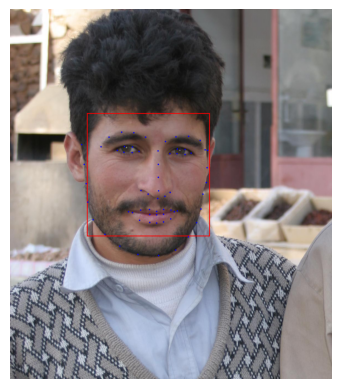

In [24]:
visualize_image(samples_train[2])

In [25]:
def visualize_data(image,landmark):
    image_clone = image.copy()
    draw = ImageDraw.Draw(image_clone)
    for (x, y) in landmark:
        draw.ellipse((x-2, y-2, x+2, y+2), fill='blue', outline='blue')

    # Display the image
    plt.imshow(image_clone)
    plt.axis('off')  # Hide axes
    plt.show()

## Create Training Data

In [13]:
def get_data(samples):
    images = []
    landmarks_list = []
    for sample in samples:
        image_path = os.path.join(root_dir, sample['filename'])
        if os.path.exists(image_path):
            image = Image.open(image_path).convert("RGB")
            width = sample['width']
            height = sample['height']
            box_left = sample["box_left"]
            box_top = sample["box_top"]
            box_width = sample["box_width"]
            box_height = sample["box_height"]
            landmarks = sample['landmarks']
            crop_image = image.crop((box_left, box_top, box_left + box_width, box_top + box_height))
            landmarks -= np.array([box_left, box_top])
            images.append(crop_image)
            landmarks_list.append(landmarks)
    return images, landmarks_list
            

In [27]:
images_train, landmarks_train = get_data(samples_train)
images_test, landmarks_test = get_data(samples_test)

In [28]:
print(len(images_train))
print(len(images_test))

4332
598


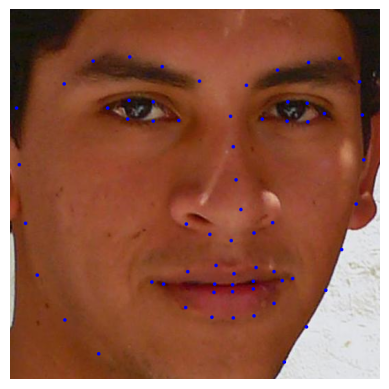

In [29]:
visualize_data(images_train[10], landmarks_train[10])

## Tranform Data


In [30]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

transform_train = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.Resize(height=256, width=256, always_apply=True),
    A.RandomCrop(height=224, width=224, always_apply=True),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
#     A.Cutout(num_holes=8, max_h_size=18, max_w_size=18, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))


transform_test = A.Compose([
    A.Resize(height=256, width=256, always_apply=True),
    A.CenterCrop(height=224, width=224, always_apply=True),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

In [31]:
def norm_transform_dataset(images,landmarks,transform):
    final_images = []
    final_landmarks = []
    
    for i in range(len(images)):
        img = images[i]
        ldm = landmarks[i]
        
        img = np.array(img)
        
        #transform
        transformed = transform(image = img, keypoints = ldm)
        transformed_img = transformed['image']
        transformed_lmd = transformed['keypoints']
        
        #normalize
        color_channels, height, width = transformed_img.shape
        transformed_lmd = transformed_lmd / np.array([width, height]) - 0.5
        
        final_images.append(transformed_img)
        final_landmarks.append(transformed_lmd)
    
    return final_images, final_landmarks

In [32]:
import torch

In [33]:
def visualize_final(transformed_cropped_image,normalized_transformed_landmarks ):
    # Define mean and std
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Reverse color transform
    def denormalize(image_tensor, mean=mean, std=std):
        # Clone and permute the tensor
        tmp = image_tensor.clone().permute(1, 2, 0)

        # Denormalize
        for t, m, s in zip(tmp, mean, std):
            t.mul_(s).add_(m)

        # Clamp the values
        return torch.clamp(tmp, 0, 1)
    cropped_image = denormalize(transformed_cropped_image)

    # Get size of cropped image
    cropped_image = (cropped_image.numpy() * 255).astype(np.uint8)
    height, width, color_channels = cropped_image.shape

    # Denormalize landmarks to pixel coordinates
    landmarks = (normalized_transformed_landmarks + 0.5) * np.array([width, height])
    
    visualize_data(Image.fromarray(cropped_image.astype(np.uint8)).convert('RGB'), landmarks)

In [34]:
final_images_train, final_landmarks_train = norm_transform_dataset(images_train, landmarks_train,transform_train)

In [35]:
final_images_test, final_landmarks_test = norm_transform_dataset(images_test, landmarks_test,transform_test)

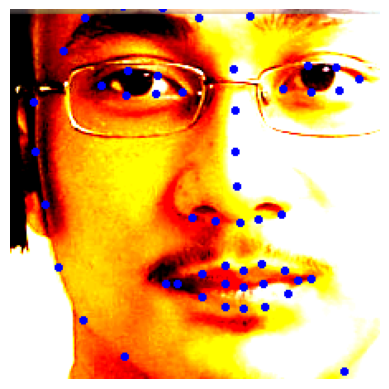

In [36]:
visualize_final(final_images_train[5],final_landmarks_train[5])

In [38]:
final_images_train_converted = torch.stack([tensor.permute(1, 2, 0) for tensor in final_images_train])
final_landmarks_train = np.array(final_landmarks_train)

final_images_test_converted = torch.stack([tensor.permute(1, 2, 0) for tensor in final_images_test])
final_landmarks_test = np.array(final_landmarks_test)

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2608349184 bytes.

In [39]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [40]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [41]:
for layer in resnet50.layers:
    layer.trainable = False

In [45]:
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(136, activation='linear')(x)
# Reshape the output to (68, 2)
output = Reshape((68, 2))(x)

# Define the new model
model = Model(inputs=resnet50.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [46]:
optimizer = Adam(learning_rate=0.001)
model.load_weights('model_checkpoint2.keras')
# checkpoint = ModelCheckpoint(
#     filepath='model_checkpoint2.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=False,
#     verbose=1
# )
# Train the model
# history = model.fit(final_images_train_converted, final_landmarks_train, batch_size=32, epochs=2, validation_data=(final_images_test_converted, final_landmarks_test),callbacks=[checkpoint])

In [47]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,825,288 (98.52 MB)

 Trainable params: 2,237,576 (8.54 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [48]:
import dlib
import cv2
detector = dlib.get_frontal_face_detector()

In [49]:
from PIL import Image, ImageDraw

In [50]:
image_test = Image.open('kaggle/working/ibug_300W_large_face_landmark_dataset/helen/trainset/232194_1.jpg')

In [51]:
face = detector(np.array(image_test))

In [52]:
def inference(image_input):
    
    faces = detector(np.array(image_input))
    draw = ImageDraw.Draw(image_input)
    print(len(faces))
    for face in faces:
        x_f, y_f, w_f, h_f = face.left(), face.top(), face.width(), face.height()
        image_crop = image_input.crop(box=(x_f,y_f,x_f + w_f, y_f + h_f))
        image_tensor = simple_transform(image_crop)
        input_ = image_tensor.permute(1,2,0).unsqueeze(dim=0)
        o = model.predict(input_)
        o = tf.squeeze(o, axis=0)
        l = (o + 0.5) * np.array( [w_f * 224 / 256, h_f * 224 / 256] ) + [16,16] + [x_f,y_f]
        for (x_, y_) in l:
            draw.ellipse((x_-2, y_-2, x_+2, y_+2), fill='blue', outline='blue')
        
        
    
#     visualize_final(image_tensor1,output)
    return image_input

In [56]:
from torchvision import transforms
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
simple_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [57]:
image_output = inference(image_test)

1
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


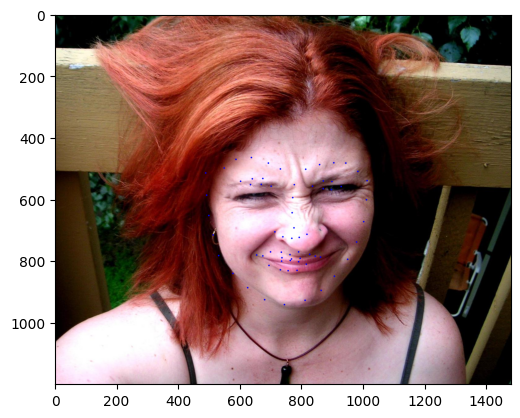

In [58]:
plt.imshow(image_output)